In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')
import zipfile

Mounted at /content/drive


In [3]:
zip_path = '/content/drive/MyDrive/gans data/Copy of img_align_celeba.zip'
extract_path = '/content/celeba_unzipped'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped to:", extract_path)


Unzipped to: /content/celeba_unzipped


In [5]:
# Path to images on Google Drive
# Corrected path based on the extraction location
data_dir = '/content/celeba_unzipped/img_align_celeba'

# Function to load and preprocess an image
def preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [64, 64])
    img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
    return img

# Load and prepare the dataset
file_paths = tf.io.gfile.glob(os.path.join(data_dir, '*.jpg'))
# Add a check to ensure file_paths is not empty
if not file_paths:
    raise FileNotFoundError(f"No JPG files found in the specified data directory: {data_dir}")

dataset = tf.data.Dataset.from_tensor_slices(file_paths)
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(10000).batch(128).prefetch(tf.data.AUTOTUNE)

In [6]:
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8*8*512, use_bias=False, input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Reshape((8, 8, 512)),
        tf.keras.layers.Conv2DTranspose(256, 5, strides=2, padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(128, 5, strides=2, padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(3, 5, strides=1, padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = build_generator()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 5, strides=2, padding='same', input_shape=[64, 64, 3]),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(128, 5, strides=2, padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(256, 5, strides=2, padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
    ])
    return model

discriminator = build_discriminator()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    return cross_entropy(tf.ones_like(real_output), real_output) + \
           cross_entropy(tf.zeros_like(fake_output), fake_output)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [9]:
epochs = 15                # More epochs since batch size is smaller
noise_dim = 100            # Match the generator's input shape
num_examples = 8           # Fewer images for preview (3x3 grid)
BATCH_SIZE = 64            # Smaller batch size
seed = tf.random.normal([num_examples, noise_dim])  # Fixed seed for visual tracking


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss

Epoch 1/15


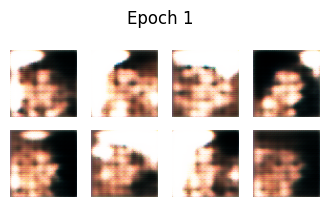

Epoch 2/15


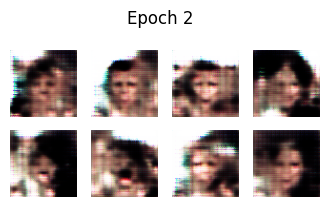

Epoch 3/15


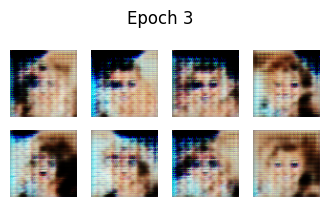

Epoch 4/15


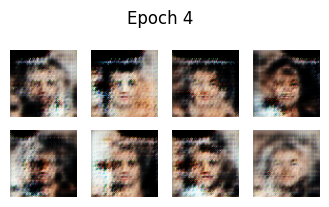

Epoch 5/15


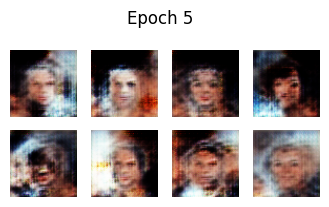

Epoch 6/15


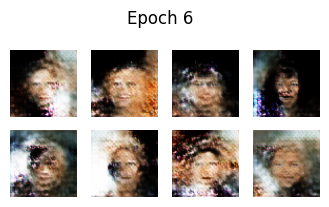

Epoch 7/15


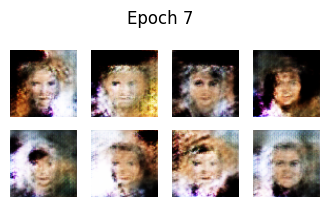

Epoch 8/15


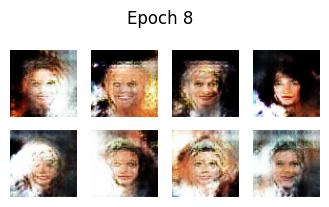

Epoch 9/15


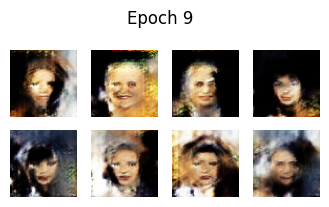

Epoch 10/15


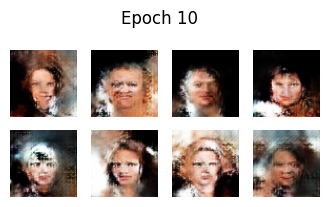

Epoch 11/15


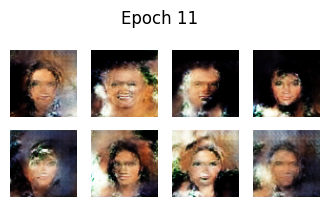

Epoch 12/15


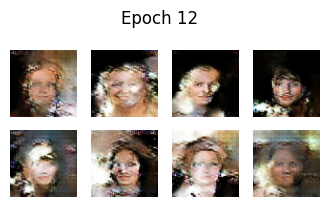

Epoch 13/15


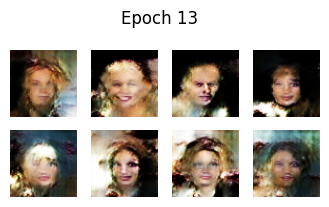

Epoch 14/15


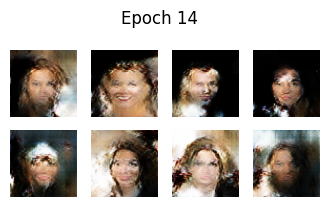

Epoch 15/15


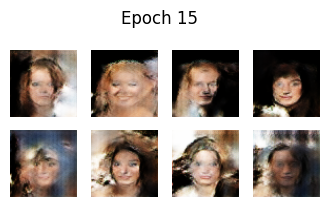

In [10]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        img = (predictions[i] + 1.0) / 2.0
        plt.imshow(img)
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}')
    plt.savefig(f'generated_epoch_{epoch}.png')
    plt.show()

gen_losses = []
disc_losses = []

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")
    g_loss_epoch = []
    d_loss_epoch = []

    for image_batch in dataset:
        g_loss, d_loss = train_step(image_batch)
        g_loss_epoch.append(g_loss)
        d_loss_epoch.append(d_loss)

    gen_losses.append(np.mean(g_loss_epoch))
    disc_losses.append(np.mean(d_loss_epoch))

    generate_and_save_images(generator, epoch, seed)


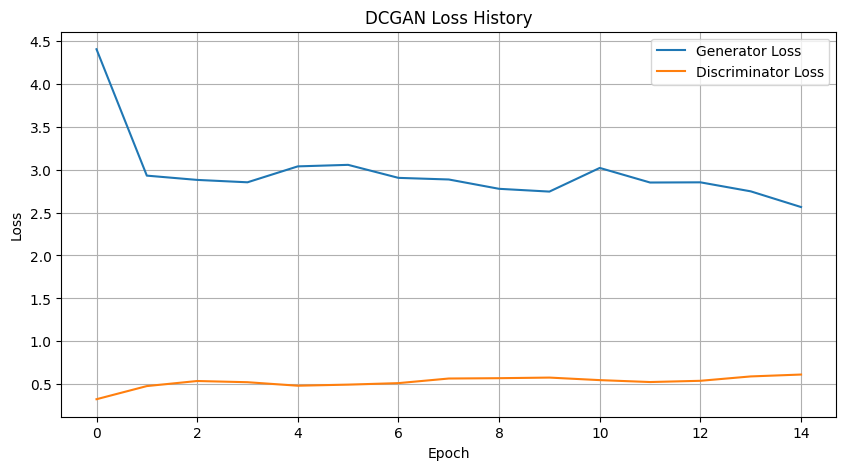

In [11]:
plt.figure(figsize=(10,5))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DCGAN Loss History')
plt.legend()
plt.grid(True)
plt.savefig("loss_plot.png")
plt.show()


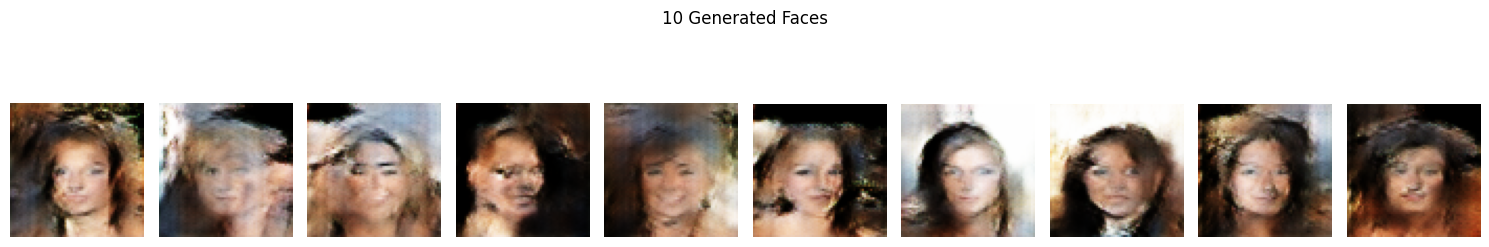

In [12]:
final_noise = tf.random.normal([10, noise_dim])
final_images = generator(final_noise, training=False)
final_images = (final_images + 1.0) / 2.0

plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(final_images[i])
    plt.axis("off")
plt.suptitle("10 Generated Faces")
plt.tight_layout()
plt.savefig("10_generated_faces.png")
plt.show()
